# Load in the data

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Osteoarthritis dataset/All Clinical/cleaned_data.csv')

df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


,ID,P01KPNREV,P01KPNLEV,P01KPACT30,P01HPNR12,P01HPNL12,V00SF2,V00SF3,V00SF8,V00WPRKN1,V00WPRKN2,V00P7RKFR,V00KSXRKN1,V00DIRKN1,V00DIRKN2,V00DIRKN14,V00WPLKN1,V00WPLKN2,V00P7LKFR,V00KSXLKN1,V00DILKN1,V00DILKN2,V00DILKN14,V00KOOSFX5,P02KPNRCV,P02KPNLCV,P01KPR30CV,P01KPL30CV,P01KPACTCV,P01HPR12CV,P01HPL12CV,P01KPA30CV,V00P7RKRCV,V00P7LKRCV,P01PMRKRCV,P01PMLKRCV,V00WOMTSL,V00WOMTSR,P01BL12SXL,P01BL12SXR,...,V00RUBCV,V00CAPSNCV,V00BRACCV,V00YOGACV,V00HERBCV,V00RELACV,V00SPIRCV,P01RASTASV,P02KSURGCV,V00OTHCAMC,V00OTHCAM,V00DISCOMF,V00LFXCOMP,V00LFXPN,V00EKRSL,V00REXPN,V00EKRSR,V00RFXCOMP,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,V00VITDCV,V00CALCMCV,V00VIT9,V00VIT1,P01BMI,V00PASE,P01FAMKR,P02WTGA,V00RKEFFB,V00RKEFFPT,V00LKEFFB,V00LKEFFPT,V00RKRFXPN,V00LKRFXPN,V00LLWGT,V00RLWGT,cumulative_outcome
0,9000296,Yes,No,No,Yes,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,Yes,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,84.0,152.0,73.00,495.5,260.7,Didn t take,Didn t take,No,Yes,29.8,190.0,No,No,No,No,No,No,No,No,12.0,18.0,No
1,9000622,Yes,No,Yes,Yes,No,"Yes, limited a little","Yes, limited a little",Moderately,Mild,Mild,Daily,Sometimes,None,Mild,None,None,None,Never,Never,None,None,None,Moderate,Yes,No,Yes,No,Limits,Yes,No,Yes,3,No pain,2,No pain,0.0,20.9,Neither,Both IEI and SV,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,136.0,64.36,679.2,70.3,Every day,Every day,Yes,No,22.7,157.0,No,No,No,No,No,No,Yes,No,14.0,14.0,Yes
2,9001695,Yes,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Monthly,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,No,No,No,1,No pain,1,No pain,0.0,NaN,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,70.0,115.0,13.01,447.2,63.1,No vitamins/minerals taken in past year,No vitamins/minerals taken in past year,No,No,28.6,280.0,Yes,No,Yes,Yes,No,No,No,No,13.0,13.0,Yes
3,9001897,No,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,Yes,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,IEI only,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,82.0,150.0,228.89,785.9,57.7,1-3 days per week,1-3 days per week,Yes,Yes,25.9,156.0,No,No,Yes,No,No,No,No,No,16.0,17.0,Yes
4,9002411,Yes,No,No,No,No,"Yes, limited a little","Yes, limited a little",A little bit,None,Mild,Never,Never,None,Mild,None,None,None,Never,Never,None,Mild,None,None,No,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,1.1,2.1,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,110.0,29.25,551.3,164.4,Didn t take,Didn t take,No,No,31.8,54.0,No,Yes,No,No,No,No,No,No,18.0,22.0,No


In [ ]:
## Replace 'No' and 'Yes' by 0 and 1 in the outcome column

df['cumulative_outcome'] = df['cumulative_outcome'].apply(lambda x: 1 if x == 'Yes' else 0)
df.head()

,ID,P01KPNREV,P01KPNLEV,P01KPACT30,P01HPNR12,P01HPNL12,V00SF2,V00SF3,V00SF8,V00WPRKN1,V00WPRKN2,V00P7RKFR,V00KSXRKN1,V00DIRKN1,V00DIRKN2,V00DIRKN14,V00WPLKN1,V00WPLKN2,V00P7LKFR,V00KSXLKN1,V00DILKN1,V00DILKN2,V00DILKN14,V00KOOSFX5,P02KPNRCV,P02KPNLCV,P01KPR30CV,P01KPL30CV,P01KPACTCV,P01HPR12CV,P01HPL12CV,P01KPA30CV,V00P7RKRCV,V00P7LKRCV,P01PMRKRCV,P01PMLKRCV,V00WOMTSL,V00WOMTSR,P01BL12SXL,P01BL12SXR,...,V00RUBCV,V00CAPSNCV,V00BRACCV,V00YOGACV,V00HERBCV,V00RELACV,V00SPIRCV,P01RASTASV,P02KSURGCV,V00OTHCAMC,V00OTHCAM,V00DISCOMF,V00LFXCOMP,V00LFXPN,V00EKRSL,V00REXPN,V00EKRSR,V00RFXCOMP,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,V00VITDCV,V00CALCMCV,V00VIT9,V00VIT1,P01BMI,V00PASE,P01FAMKR,P02WTGA,V00RKEFFB,V00RKEFFPT,V00LKEFFB,V00LKEFFPT,V00RKRFXPN,V00LKRFXPN,V00LLWGT,V00RLWGT,cumulative_outcome
0,9000296,Yes,No,No,Yes,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,Yes,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,84.0,152.0,73.00,495.5,260.7,Didn t take,Didn t take,No,Yes,29.8,190.0,No,No,No,No,No,No,No,No,12.0,18.0,0
1,9000622,Yes,No,Yes,Yes,No,"Yes, limited a little","Yes, limited a little",Moderately,Mild,Mild,Daily,Sometimes,None,Mild,None,None,None,Never,Never,None,None,None,Moderate,Yes,No,Yes,No,Limits,Yes,No,Yes,3,No pain,2,No pain,0.0,20.9,Neither,Both IEI and SV,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,136.0,64.36,679.2,70.3,Every day,Every day,Yes,No,22.7,157.0,No,No,No,No,No,No,Yes,No,14.0,14.0,1
2,9001695,Yes,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Monthly,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,No,No,No,1,No pain,1,No pain,0.0,NaN,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,70.0,115.0,13.01,447.2,63.1,No vitamins/minerals taken in past year,No vitamins/minerals taken in past year,No,No,28.6,280.0,Yes,No,Yes,Yes,No,No,No,No,13.0,13.0,1
3,9001897,No,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,Yes,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,IEI only,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,82.0,150.0,228.89,785.9,57.7,1-3 days per week,1-3 days per week,Yes,Yes,25.9,156.0,No,No,Yes,No,No,No,No,No,16.0,17.0,1
4,9002411,Yes,No,No,No,No,"Yes, limited a little","Yes, limited a little",A little bit,None,Mild,Never,Never,None,Mild,None,None,None,Never,Never,None,Mild,None,None,No,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,1.1,2.1,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,110.0,29.25,551.3,164.4,Didn t take,Didn t take,No,No,31.8,54.0,No,Yes,No,No,No,No,No,No,18.0,22.0,0


# Data Cleaning and pre-processing

In [ ]:
## Drop first column (ID of the patient)

df = df.drop('ID', axis='columns')


## Check columns to convert to dummies, because the model will not accept non numerical values

columns_dummies = []

for col in df.columns:
  if df[col].dtype != 'float64' and df[col].dtype != 'int64':
    columns_dummies.append(col)

print(f'Number of columns to dummy encode = {len(columns_dummies)} out of {len(df.columns)}')


df_enc = pd.get_dummies(df, columns = columns_dummies, drop_first = True)

Number of columns to dummy encode = 103 out of 121


In [ ]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3702 entries, 0 to 3701
Columns: 228 entries, V00WOMTSL to V00LKRFXPN_Yes
dtypes: float64(17), int64(1), uint8(210)
memory usage: 1.2 MB


In [ ]:
df_enc.head()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,cumulative_outcome,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,"V00SF2_Yes, limited a little","V00SF2_Yes, limited a lot","V00SF3_Yes, limited a little","V00SF3_Yes, limited a lot",V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not at all,V00SF8_Quite a bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,...,V00HERBCV_Yes,V00RELACV_Yes,V00SPIRCV_Yes,"P01RASTASV_DK to RA/inflam arth, no/dk to meds",P01RASTASV_Does not report RA/inflam arth,"P01RASTASV_Report RA/inflam arth, dk to all meds","P01RASTASV_Report RA/inflam arth, no to all meds","P01RASTASV_Report RA/inflam arth, no/dk to meds",P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4-6 days per week,V00VITDCV_A few days per month,V00VITDCV_Didn t take,V00VITDCV_Every day,V00VITDCV_No vitamins/minerals taken in past year,V00CALCMCV_4-6 days per week,V00CALCMCV_A few days per month,V00CALCMCV_Didn t take,V00CALCMCV_Every day,V00CALCMCV_No vitamins/minerals taken in past year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too tender to examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too tender to examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes
0,0.0,0.0,0.0,0.0,1727.2,75.0,84.1,72.7,84.0,152.0,73.00,495.5,260.7,29.8,190.0,12.0,18.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.0,20.9,15.0,1.0,1625.6,54.5,62.3,50.9,60.0,136.0,64.36,679.2,70.3,22.7,157.0,14.0,14.0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.0,NaN,0.0,0.0,1625.6,59.1,79.5,52.3,70.0,115.0,13.01,447.2,63.1,28.6,280.0,13.0,13.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
3,0.0,0.0,0.0,0.0,1778.0,79.5,84.1,70.5,82.0,150.0,228.89,785.9,57.7,25.9,156.0,16.0,17.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,1.1,2.1,0.0,0.0,1879.6,81.8,106.8,45.5,60.0,110.0,29.25,551.3,164.4,31.8,54.0,18.0,22.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


##Dealing with missing values

In [ ]:
# Check if we have to deal with Nan values
columns_with_nan_values = []
for col in df_enc.columns:
  if df_enc[col].isnull().values.any() == True:
    columns_with_nan_values.append(col)

print(columns_with_nan_values)

['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM', 'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS', 'V00DTVITD', 'V00DTCALC', 'V00DTCHOL', 'P01BMI', 'V00PASE', 'V00LLWGT', 'V00RLWGT']


In [ ]:
# We replace the Nan values by the mean of each column
for col in columns_with_nan_values:
  col_mean = df[col].describe()['mean']
  df_enc[col] = df[col].fillna(col_mean)

df_enc.head()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,cumulative_outcome,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,"V00SF2_Yes, limited a little","V00SF2_Yes, limited a lot","V00SF3_Yes, limited a little","V00SF3_Yes, limited a lot",V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not at all,V00SF8_Quite a bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,...,V00HERBCV_Yes,V00RELACV_Yes,V00SPIRCV_Yes,"P01RASTASV_DK to RA/inflam arth, no/dk to meds",P01RASTASV_Does not report RA/inflam arth,"P01RASTASV_Report RA/inflam arth, dk to all meds","P01RASTASV_Report RA/inflam arth, no to all meds","P01RASTASV_Report RA/inflam arth, no/dk to meds",P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4-6 days per week,V00VITDCV_A few days per month,V00VITDCV_Didn t take,V00VITDCV_Every day,V00VITDCV_No vitamins/minerals taken in past year,V00CALCMCV_4-6 days per week,V00CALCMCV_A few days per month,V00CALCMCV_Didn t take,V00CALCMCV_Every day,V00CALCMCV_No vitamins/minerals taken in past year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too tender to examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too tender to examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes
0,0.0,0.000000,0.0,0.0,1727.2,75.0,84.1,72.7,84.0,152.0,73.00,495.5,260.7,29.8,190.0,12.0,18.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.0,20.900000,15.0,1.0,1625.6,54.5,62.3,50.9,60.0,136.0,64.36,679.2,70.3,22.7,157.0,14.0,14.0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.0,10.076808,0.0,0.0,1625.6,59.1,79.5,52.3,70.0,115.0,13.01,447.2,63.1,28.6,280.0,13.0,13.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
3,0.0,0.000000,0.0,0.0,1778.0,79.5,84.1,70.5,82.0,150.0,228.89,785.9,57.7,25.9,156.0,16.0,17.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,1.1,2.100000,0.0,0.0,1879.6,81.8,106.8,45.5,60.0,110.0,29.25,551.3,164.4,31.8,54.0,18.0,22.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
## Check if there are still NaN values in data frame
df_enc.isnull().values.any()

False

In [ ]:
## Rename columns to have format usable with the Stats Model Formula input

print('Before = ', df_enc.columns)

# Replace all spaces and symbols by underscores

df_enc.columns = df_enc.columns.str.replace(' ', '_')
df_enc.columns = df_enc.columns.str.replace(',', '_')
df_enc.columns = df_enc.columns.str.replace(':', '_')
df_enc.columns = df_enc.columns.str.replace('/', '_')
df_enc.columns = df_enc.columns.str.replace('-', '_')

print('After = ', df_enc.columns)

Before =  Index(['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM',
       'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS',
       ...
       'P01FAMKR_Yes', 'P02WTGA_Yes', 'V00RKEFFB_Yes',
       'V00RKEFFPT_Too tender to examine', 'V00RKEFFPT_Yes', 'V00LKEFFB_Yes',
       'V00LKEFFPT_Too tender to examine', 'V00LKEFFPT_Yes', 'V00RKRFXPN_Yes',
       'V00LKRFXPN_Yes'],
      dtype='object', length=228)
After =  Index(['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM',
       'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS',
       ...
       'P01FAMKR_Yes', 'P02WTGA_Yes', 'V00RKEFFB_Yes',
       'V00RKEFFPT_Too_tender_to_examine', 'V00RKEFFPT_Yes', 'V00LKEFFB_Yes',
       'V00LKEFFPT_Too_tender_to_examine', 'V00LKEFFPT_Yes', 'V00RKRFXPN_Yes',
       'V00LKRFXPN_Yes'],
      dtype='object', length=228)


## Split the data set into a testing and a training set

In [ ]:
## Divide data set in training and testing set

df_train, df_test = train_test_split(df_enc, test_size=0.3, random_state=88)
df_train.shape, df_test.shape

((2591, 228), (1111, 228))

# Random Forest Classifier





In [ ]:
#Random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Creating a model
y_train = df_train['cumulative_outcome']
x_train = df_train.drop(columns = ['cumulative_outcome'], axis = 1)
y_test = df_test['cumulative_outcome']
x_test = df_test.drop(columns = ['cumulative_outcome'], axis = 1)

In [ ]:
# Train the random forest
rf = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0)
rf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=0)

In [ ]:
## Making predictions on the testing set
y_pred_rf = rf.predict(x_test)
## Obtaining the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print ("Confusion Matrix : \n", cm_rf, "\n")
# Accuracy
print("Accuracy : \n", (cm_rf.ravel()[0]+cm_rf.ravel()[3])/sum(cm_rf.ravel()),"\n")
#True positive rate
tpr = (cm_rf.ravel()[3])/(cm_rf.ravel()[2]+cm_rf.ravel()[3])
print("TPR : \n", tpr,"\n")

#False positive rate
fpr = (cm_rf.ravel()[1])/(cm_rf.ravel()[0]+cm_rf.ravel()[1])
print("FPR : \n", fpr,"\n")

Confusion Matrix : 
 [[525  92]
 [345 149]] 

Accuracy : 
 0.6066606660666066 

TPR : 
 0.3016194331983806 

FPR : 
 0.14910858995137763 



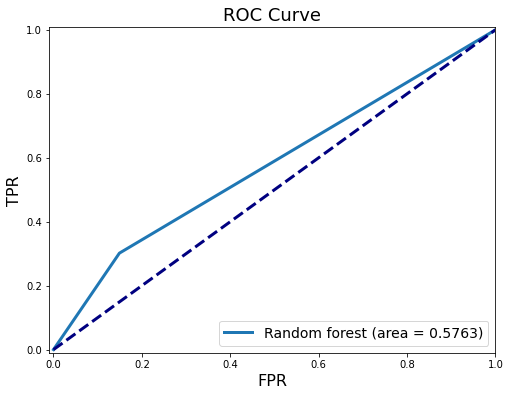

In [ ]:
## ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Random forest (area = {:0.4f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

### Random Forest with Cross Validation

In [ ]:
import time
from sklearn.model_selection import GridSearchCV
#Grid search on the maximum number of feature per tree
grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'),
              'min_samples_leaf': [5],
              'n_estimators': [500],
              'random_state': [88]} 

tic = time.time()

rf = RandomForestClassifier() 
rf_cv = GridSearchCV(rf, param_grid=grid_values, cv=5)
rf_cv.fit(x_train, y_train)

toc = time.time()
print('time:', round(toc-tic, 2),'s')

time: 183.52 s


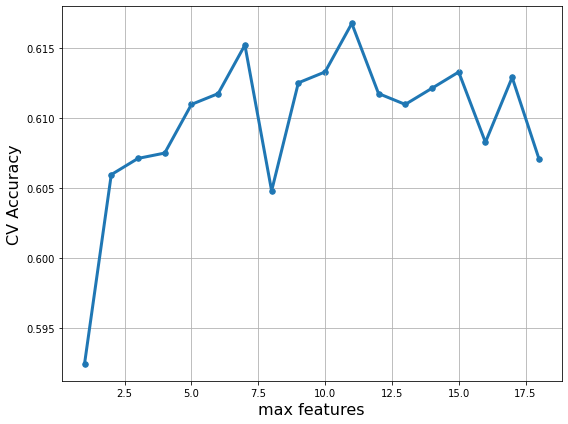

Best parameters {'max_features': 11, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


In [ ]:
#Plot of the accuracy for each maximum number of features value, to select the value that leads to the highest accuracy possible
max_features = rf_cv.cv_results_['param_max_features'].data
accuracy_score = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(max_features, accuracy_score, s=30)
plt.plot(max_features, accuracy_score, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

print('Best parameters', rf_cv.best_params_)

In [ ]:
## Making predictions on the testing set
y_pred_rf_cv = rf_cv.predict(x_test)
## Obtaining the confusion matrix
cm_rf_cv = confusion_matrix(y_test, y_pred_rf_cv)
print ("Confusion Matrix : \n", cm_rf_cv, "\n")
# Accuracy
print("Accuracy : \n", (cm_rf_cv.ravel()[0]+cm_rf_cv.ravel()[3])/sum(cm_rf_cv.ravel()),"\n")
#True positive rate
tpr = (cm_rf_cv.ravel()[3])/(cm_rf_cv.ravel()[2]+cm_rf_cv.ravel()[3])
print("TPR : \n", tpr,"\n")

#False positive rate
fpr = (cm_rf_cv.ravel()[1])/(cm_rf_cv.ravel()[0]+cm_rf_cv.ravel()[1])
print("FPR : \n", fpr,"\n")

Confusion Matrix : 
 [[550  67]
 [362 132]] 

Accuracy : 
 0.6138613861386139 

TPR : 
 0.26720647773279355 

FPR : 
 0.1085899513776337 



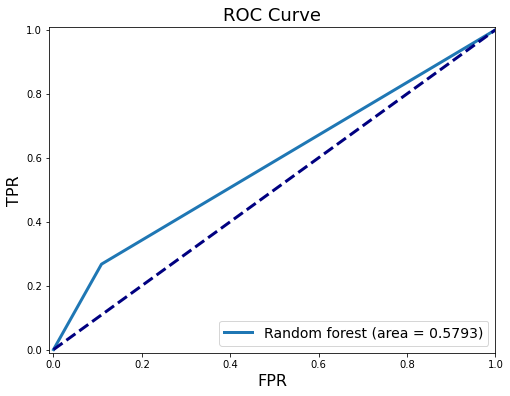

In [ ]:
## ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_cv)
roc_auc_rf_cv = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Random forest (area = {:0.4f})'.format(roc_auc_rf_cv))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## Feature Importance Analysis
Each feature will have an importance score, computed thanks to how critical they have been to split each decision tree of the random forest model. This analysis will help us to interpret the random forest model, to know on which criteria it predicted the outcome.

In [ ]:
pd.DataFrame({'Feature' : x_train.columns, 
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)

,Feature,Importance score
0,V00WOMTSL,3.0
1,V00WOMTSR,3.1
2,P01KPACDCV,0.7
3,V00COMORB,0.7
4,V00HT25MM,2.5
...,...,...
222,V00LKEFFB_Yes,0.2
223,V00LKEFFPT_Too_tender_to_examine,0.0
224,V00LKEFFPT_Yes,0.1
225,V00RKRFXPN_Yes,0.2


findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


Feature: P01BMI                              Importance: 3.6340376366947424
Feature: V00DTCHOL                           Importance: 3.3487055811528417
Feature: V00PASE                             Importance: 3.28620479100094
Feature: V00DTCALC                           Importance: 3.2522299695558297
Feature: V00DTVITD                           Importance: 3.2355900217230475
Feature: V00BPSYS                            Importance: 3.1232582392101818
Feature: V00WOMTSR                           Importance: 3.0997647124565537
Feature: V00WTMAXKG                          Importance: 3.0475610693603543
Feature: V00WOMTSL                           Importance: 3.013200040499116
Feature: V00WTMINKG                          Importance: 2.9297953542139368
Feature: V00WT25KG                           Importance: 2.663661372140834
Feature: V00LLWGT                            Importance: 2.475550041302802
Feature: V00HT25MM                           Importance: 2.4584745614348344
Feature: V00RLWGT

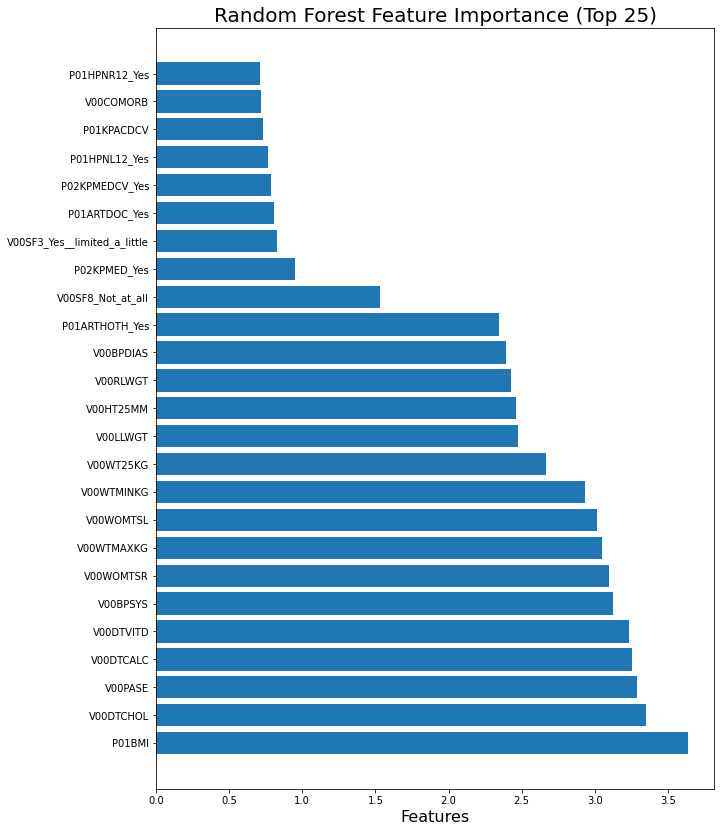

In [ ]:
pd.DataFrame({'Feature' : x_train.columns, 
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)

feature_importances = list(zip(x_train.columns,100*rf_cv.best_estimator_.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked[:25]];


# Plot the top 25 feature importance
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()